
# Audio PreProcessing

**Authors**: [José Antonio Ruiz Heredia](josrui05@ucm.es) [Néstor ](@ucm.es)


## 1. CARGAR DATOS

Importamos las librerias y las rutas de nuestros datos.

In [190]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import random
import os
from Constants.DataPaths import *
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as FF
import audiomentations
from audiomentations import Compose,Gain,PitchShift, AddGaussianNoise, Reverse

Seleccionamos un audio aleatorio y sus respectivas modificaciones

In [191]:
# Select a random audio from the original dataset
def select_random_audio(original_path):
    archives = os.listdir(original_path)
    
    if not archives:
        return None
    
    # Select a random audio from the original folder
    random_index = random.randint(0,len(archives)-1)
    random_audio = archives[random_index]
    
    # Build the path to the selected audio
    audio_path = os.path.join(original_path, random_audio)
    
    # Name without the extension
    audio_name = os.path.splitext(random_audio)[0]
    
    return random_audio, audio_name, audio_path


# Search the forgered audios based on the original audio name
def search_forgered_audio(path, audio_name):
    files_found = []
    files = os.listdir(path)
    
    for file in files:
        if file.startswith(audio_name) and "_" in file:
            files_found.append(os.path.join(path, file))
            
    return files_found

    
def select_audios(files_found_splicing, files_found_copy_move):
    # Select random index
    random_index = random.randint(0,min(len(files_found_splicing)-1,len(files_found_copy_move)-1))
    
    # Take the random audios from the list of forgered audios matching the original audio
    random_audio_splicing = files_found_splicing[random_index]
    random_audio_cm = files_found_copy_move[random_index]
    
    return random_audio_splicing, random_audio_cm


Mostramos los ``audios seleccionados`` elegidos aleatoriamente.

In [192]:
selected_audio_path, audio_name, audio_path = select_random_audio(ORIGINAL_DATASET_PATH)

if selected_audio_path is not None:
    print(f"Audio seleccionado: {audio_path}")
else:
    print("La carpeta está vacía.")

files_found_splicing = search_forgered_audio(SPLICING_DATASET_PATH, audio_name)
files_found_copy_move = search_forgered_audio(COPY_MOVE_DATASET_PATH, audio_name)
audio_splicing, audio_copy_move = select_audios(files_found_splicing, files_found_copy_move)

print(f"Audio respectivo original sin modificacionescon splicing: {audio_splicing}")
print(f"Audio respectivo con copy-move: {audio_copy_move}")

Audio seleccionado: /home/jose/src/TFG/DatasetConcatenation/OriginalDataset/SI817.WAV
Audio respectivo original sin modificacionescon splicing: /home/jose/src/TFG/DatasetConcatenation/SplicingDataset/SI817_0.WAV
Audio respectivo con copy-move: /home/jose/src/TFG/DatasetConcatenation/CopyMoveDataset/SI817_0.WAV


## 2. VISUALIZACIÓN DE DATOS

In [193]:
from IPython.display import Audio
from matplotlib.patches import Rectangle


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, xlabel="time", ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")



def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

##### Espectrograma

Cargamos los audios usando ``torchaudio``




In [194]:
# Load audios
SPEECH_WAVEFORM_ORIGINAL, SAMPLE_RATE_ORIGINAL = torchaudio.load(audio_path)
SPEECH_WAVEFORM_SPLICING, SAMPLE_RATE_SPLICING = torchaudio.load(audio_splicing)
SPEECH_WAVEFORM_COPY_MOVE, SAMPLE_RATE_COPY_MOVE = torchaudio.load(audio_copy_move)

# Define transform
spectrogram = T.Spectrogram(n_fft=1024, hop_length=128)

# Perform transforms
spec_original = spectrogram(SPEECH_WAVEFORM_ORIGINAL)
spec_splicing = spectrogram(SPEECH_WAVEFORM_SPLICING)
spec_copy_move = spectrogram(SPEECH_WAVEFORM_COPY_MOVE)

Creamos subplots con ``waveform`` y ``spectogram`` para cada audio seleccionado.

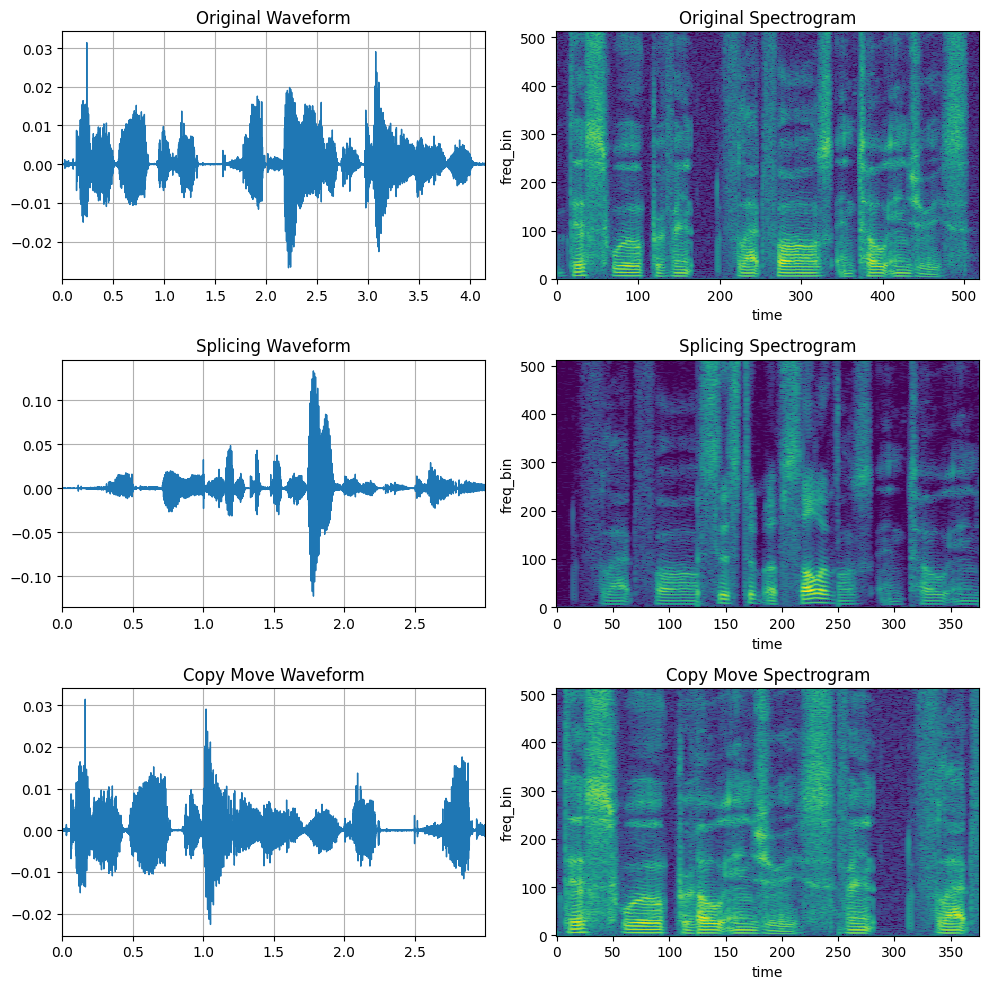

In [195]:
# Create a figure and axes
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Plot ORIGINAL AUDIO
plot_waveform(SPEECH_WAVEFORM_ORIGINAL, SAMPLE_RATE_ORIGINAL, title="Original Waveform", ax=axs[0, 0])
plot_spectrogram(spec_original[0], title="Original Spectrogram", ax=axs[0, 1])

# Plot SPLICING AUDIO
plot_waveform(SPEECH_WAVEFORM_SPLICING, SAMPLE_RATE_SPLICING, title="Splicing Waveform", ax=axs[1, 0])
plot_spectrogram(spec_splicing[0], title="Splicing Spectrogram", ax=axs[1, 1])

# Plot COPY MOVE AUDIO
plot_waveform(SPEECH_WAVEFORM_COPY_MOVE, SAMPLE_RATE_COPY_MOVE, title="Copy Move Waveform", ax=axs[2, 0])
plot_spectrogram(spec_copy_move[0], title="Copy Move Spectrogram", ax=axs[2, 1])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Escuchamos los diferentes audios seleccionados.

In [196]:
Audio(SPEECH_WAVEFORM_ORIGINAL.numpy(), rate=SAMPLE_RATE_ORIGINAL)

In [197]:
Audio(SPEECH_WAVEFORM_SPLICING.numpy(), rate=SAMPLE_RATE_SPLICING)

In [198]:

Audio(SPEECH_WAVEFORM_COPY_MOVE.numpy(), rate=SAMPLE_RATE_COPY_MOVE)

## 3. Características del audio

#### 3.1. Pruebas con el valor de ``n_fft``

La conversión del espectrograma se fundamenta en la transformada de Fourier, y es el ``n_fft`` lo que determina la resolución del eje de frecuencia. 

Sin embargo, con un valor de ``n_fft``más alto, la energía se distribuirá entre más ``bins``, por lo que cuando se visualice, podría parecer más borroso aunque tenga una mayor resolución.

Vamos a estudiar el espectrograma del audio de empalme para determinar con qué valor de ``n_fft`` podemos detectar mejor la manipulación.

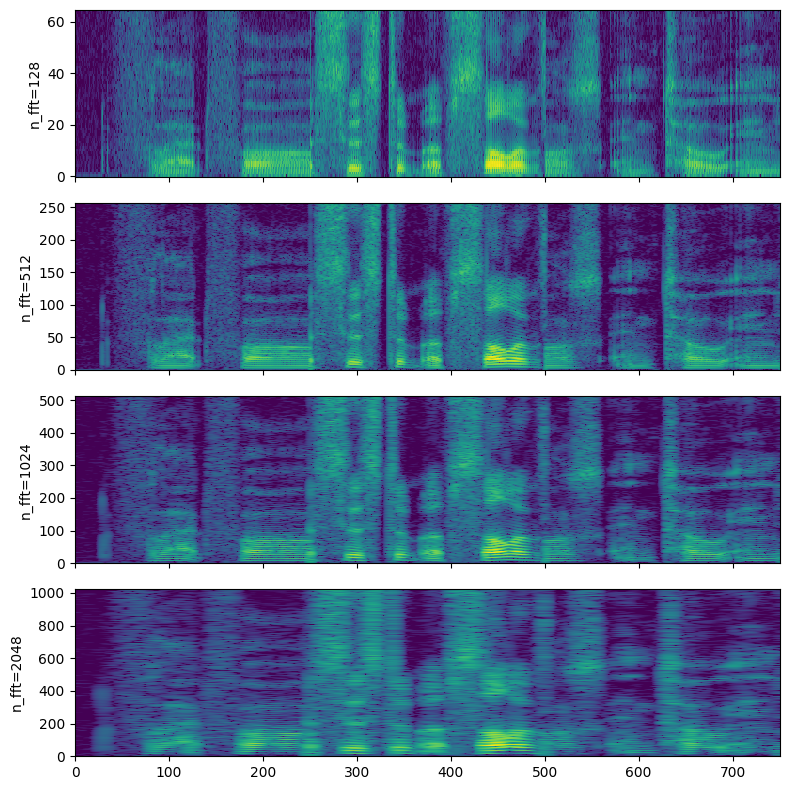

In [199]:
n_ffts = [128, 512, 1024, 2048]
hop_length = 64

specs_n_fft = []

# Iterate over each n_fft value
for n_fft in n_ffts:
    spectrogram_n_fft = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec_test_n_fft = spectrogram_n_fft(SPEECH_WAVEFORM_SPLICING)
    specs_n_fft.append(spec_test_n_fft)

# Plot the same spectogram with different n_ffts values.
fig, axs = plt.subplots(len(specs_n_fft), 1, figsize=(8, 8), sharex=True)

# Iterate over each spectrogram and plot it along with its corresponding n_fft value
for i, (spec_test_n_fft, n_fft) in enumerate(zip(specs_n_fft, n_ffts)):
    plot_spectrogram(spec_test_n_fft[0], ylabel=f"n_fft={n_fft}", ax=axs[i])
    axs[i].set_xlabel(None)
    
fig.tight_layout()

Al comparar señales, es preferible utilizar la misma frecuencia de muestreo; sin embargo, si se usa una frecuencia de muestreo diferente, hay que tener cuidado al interpretar el significado de ``n_fft``. 

El parámetro ``n_fft`` determina la resolución del eje de frecuencia para una frecuencia de muestreo dada. 
En otras palabras, lo que representa cada ``bin`` en el eje de frecuencia está sujeto a la frecuencia de muestreo.

Como hemos visto anteriormente, cambiar el valor de ``n_fft`` no cambia la cobertura del rango de frecuencia para la misma señal de entrada.


#### 3.2. Pruebas con el valor de ``hop_length``

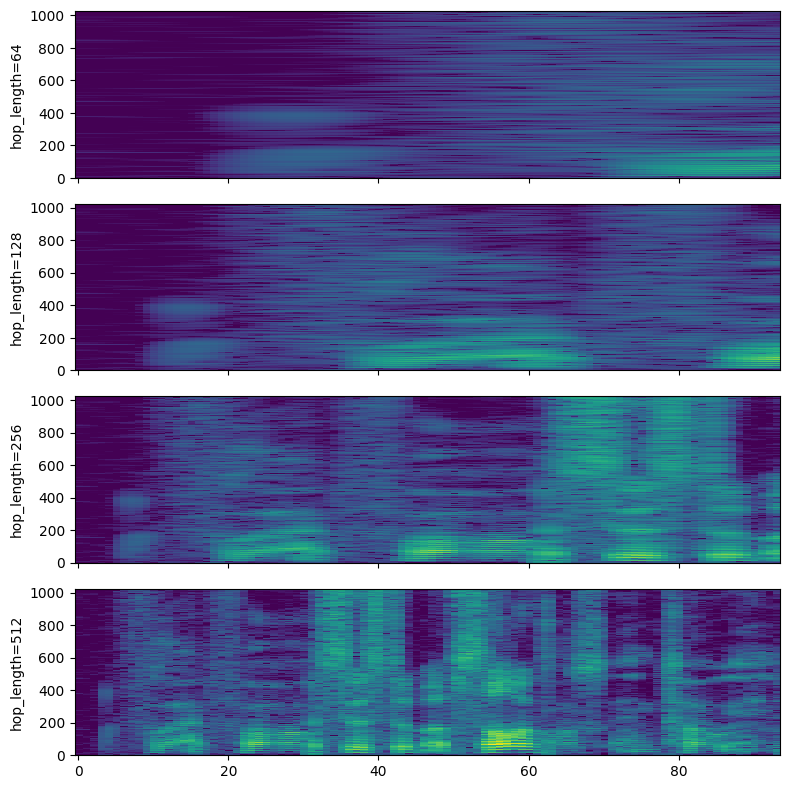

In [200]:
hop_lengths = [64, 128, 256, 512]
n_fft = 2048

specs_hop_length = []

# Iterate over each hop_length value
for hop_length in hop_lengths:
    spectrogram_hop_length = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec_test_hop_length = spectrogram_hop_length(SPEECH_WAVEFORM_SPLICING)
    specs_hop_length.append(spec_test_hop_length)

# Plot the same spectogram with different hop_lengths values.
fig, axs = plt.subplots(len(specs_hop_length), 1, figsize=(8, 8), sharex=True)

# Iterate over each spectrogram and plot it along with its corresponding hop_length value
for i, (spec_test_hop_length, hop_length) in enumerate(zip(specs_hop_length, hop_lengths)):
    plot_spectrogram(spec_test_hop_length[0], ylabel=f"hop_length={hop_length}", ax=axs[i])
    axs[i].set_xlabel(None)
    
fig.tight_layout()


#### 3.3. Pruebas con el ``Resize``

Función para redimensionar la imagen del espectrograma

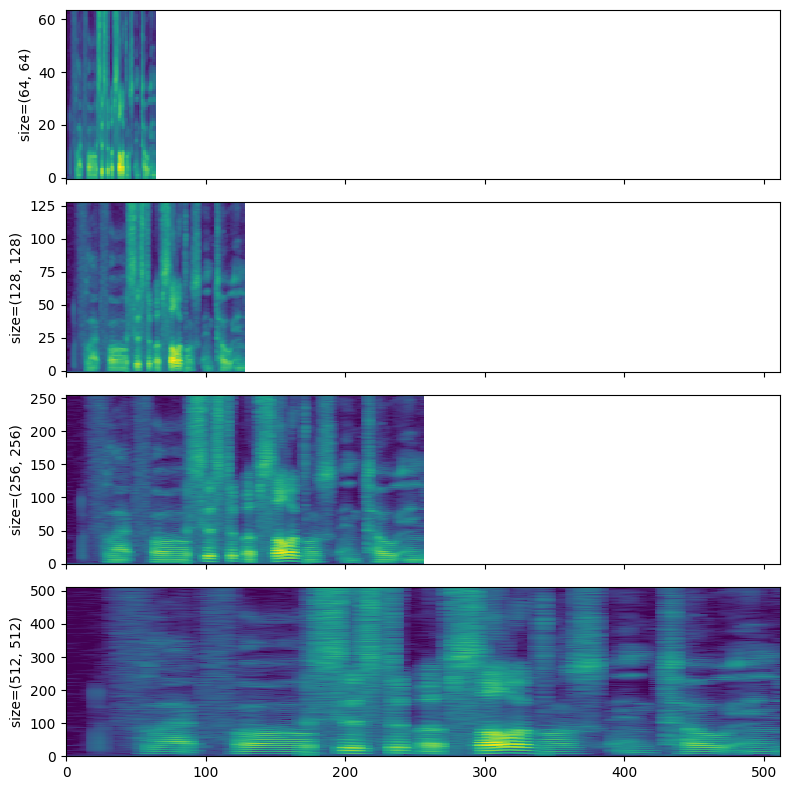

In [201]:
# Image sizes
image_sizes = [(64, 64), (128, 128), (256, 256), (512, 512)]
n_fft = 2048
hop_length = 512

specs_image_size = []

# Iterate over each image_size value
for size in image_sizes:
    # Spectogram with the current size
    spectrogram_size = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec_test_size = spectrogram_size(SPEECH_WAVEFORM_SPLICING)
    # Resize
    spec_test_size_resized = FF.resize(spec_test_size, size)
    specs_image_size.append(spec_test_size_resized)

# Plot the same spectogram with different sizes.
fig, axs = plt.subplots(len(specs_image_size), 1, figsize=(8, 8), sharex=True)

# Iterate over each spectrogram and plot it along with its corresponding size value
for i, (spec_test_size_resized, size) in enumerate(zip(specs_image_size, image_sizes)):
    plot_spectrogram(spec_test_size_resized[0], ylabel=f"size={size}", ax=axs[i])
    axs[i].set_xlabel(None)

fig.tight_layout()
plt.show()

#### 3.4. Pruebas con el valor de ``Sample``

Vamos a hacer un ``downsample`` al audio utilizando el valor que hemos cogido para ``n_fft``.



In [202]:
# Downsample to half of the original sample rate
speech2 = torchaudio.functional.resample(SPEECH_WAVEFORM_SPLICING, SAMPLE_RATE_SPLICING, SAMPLE_RATE_SPLICING // 2)

# Upsample to the original sample rate
speech3 = torchaudio.functional.resample(speech2, SAMPLE_RATE_SPLICING // 2, SAMPLE_RATE_SPLICING)

In [203]:
# Apply the same spectrogram
spectrogram = T.Spectrogram(n_fft=512)

spec0 = spectrogram(SPEECH_WAVEFORM_SPLICING)
spec2 = spectrogram(speech2)
spec3 = spectrogram(speech3)

Visualizamos los cambios del ``sample``

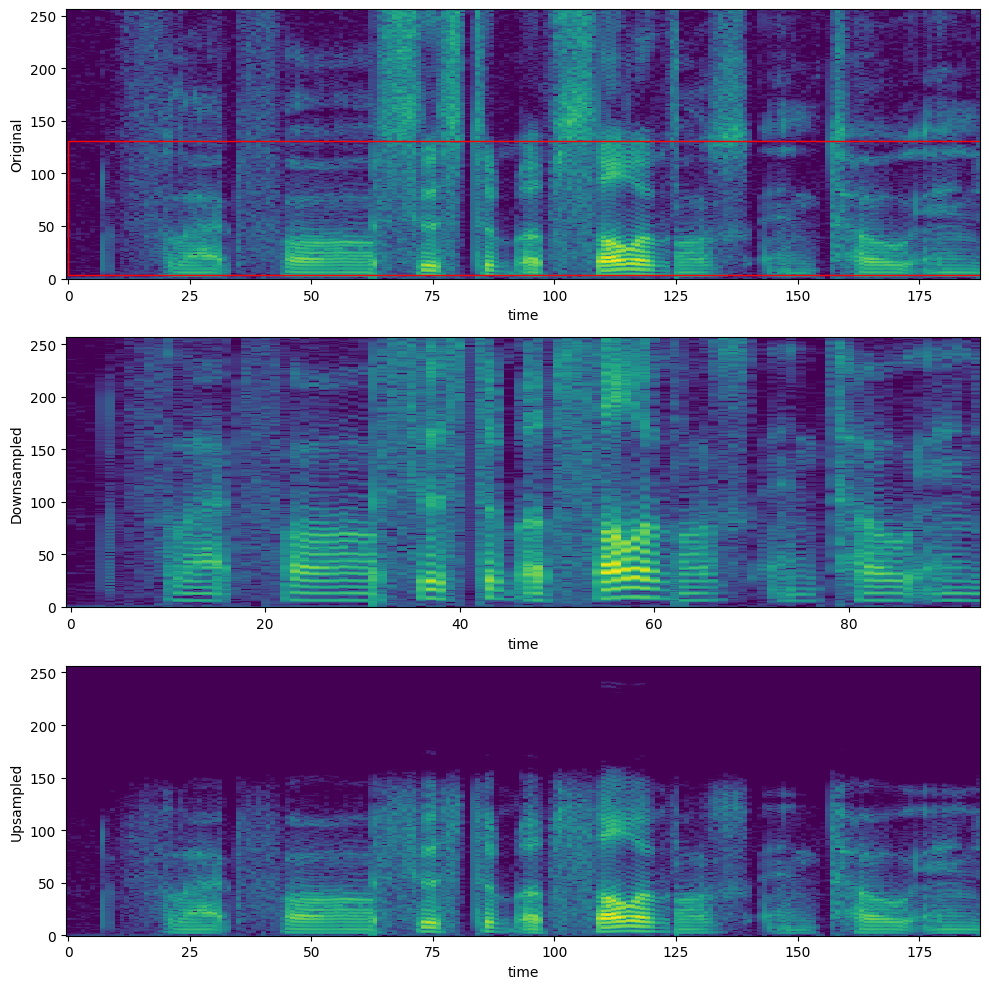

In [204]:
# Visualize it
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# ORIGINAL SPECTOGRAM
plot_spectrogram(spec0[0], ylabel="Original", ax=axs[0])
axs[0].add_patch(Rectangle((0, 3), 212, 128, edgecolor="r", facecolor="none"))

# DOWNSAMPLED SPECTOGRAM
plot_spectrogram(spec2[0], ylabel="Downsampled", ax=axs[1])

# UPSAMPLED SPECTOGRAM
plot_spectrogram(spec3[0], ylabel="Upsampled", ax=axs[2])

fig.tight_layout()

En esta visualización, el segundo gráfico ("**Downsampled**") puede dar la impresión de que el espectrograma está estirado. 

Esto se debe a que el significado de los ``bins`` de frecuencia es diferente al original. Aunque tienen el mismo número de ``bins``, en el segundo gráfico, la frecuencia solo está cubierta hasta la mitad de la frecuencia de muestreo original. 

Esto se ve más claro si volvemos a muestrear la señal reducida para que tenga la misma frecuencia de muestreo que la original.


#### 3.5. Conversión a GriffinLim

Se utiliza para recuperar la ``waveform`` de un espectograma.


In [205]:
# Define transforms
n_fft = 1024
spectrogram = T.Spectrogram(n_fft=n_fft)
griffin_lim = T.GriffinLim(n_fft=n_fft)

# Apply the transforms
spec = spectrogram(SPEECH_WAVEFORM_SPLICING)
reconstructed_waveform = griffin_lim(spec)

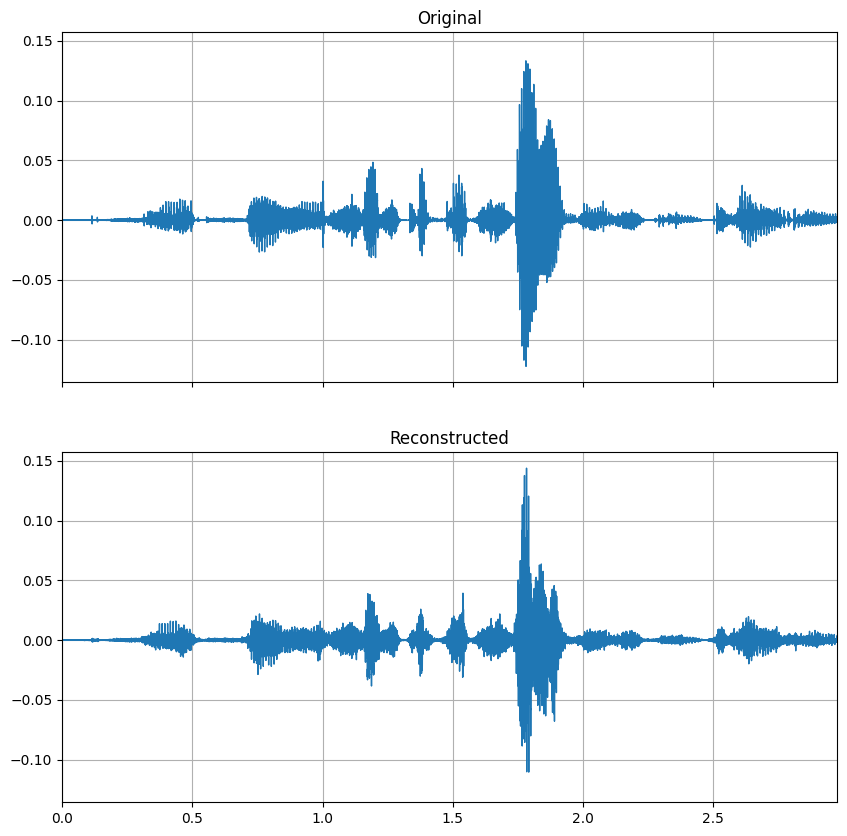

In [206]:
_, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)
plot_waveform(SPEECH_WAVEFORM_SPLICING, SAMPLE_RATE_SPLICING, title="Original", ax=axes[0])
plot_waveform(reconstructed_waveform, SAMPLE_RATE_SPLICING, title="Reconstructed", ax=axes[1])


Escuchamos el audio del espectograma recuperado.

In [207]:
Audio(reconstructed_waveform, rate=SAMPLE_RATE_SPLICING)

#### 3.6. Mel Filter Bank

In [208]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm="slaney",
)

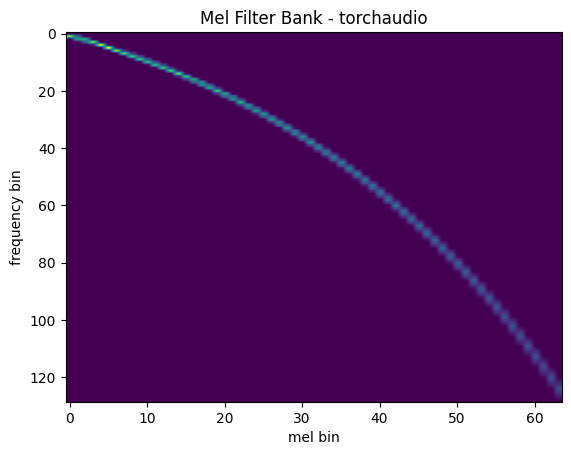

In [209]:
plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

#### 3.7. Conversión a MelSpectrogram

Un ``espectrograma de Mel`` es una **representación visual** del sonido que utiliza una escala de frecuencia Mel. 
Proporciona una visualización de cómo cambian las *intensidades de las diferentes frecuencias a lo largo del tiempo* en una señal de audio. 

Resalta características importantes del sonido para ayudar a los modelos de aprendizaje automático a extraer información relevante y realizar tareas de reconocimiento y clasificación de audio.



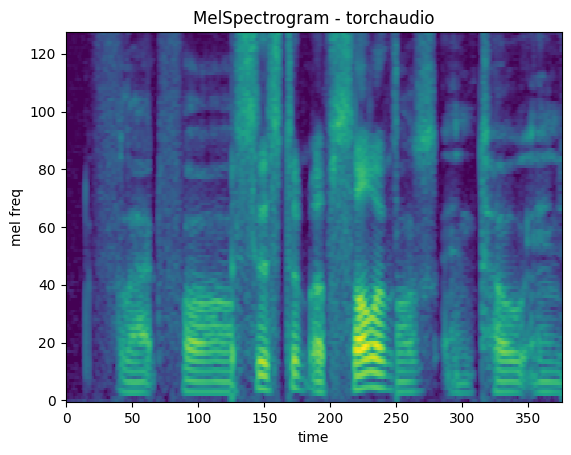

In [210]:
n_fft = 1024
win_length = None
hop_length = 128
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(SPEECH_WAVEFORM_SPLICING)
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

#### 3.8. Conversión a ``MFCC``




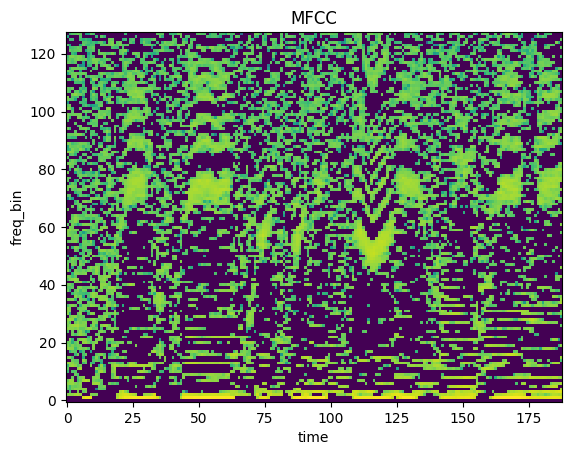

In [211]:
n_fft = 1024
win_length = None
hop_length = 256
n_mels = 128
n_mfcc = 128

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(SPEECH_WAVEFORM_SPLICING)
plot_spectrogram(mfcc[0], title="MFCC")

#### 3.8.1. Pruebas cambiando el valor de ``n_mfcc``

In [212]:
specs = []

n_fft = 1024
win_length = None
hop_length = 128
mfccs = [64, 128, 256, 512]
# MFCC (Mel-frequency cepstral coefficients) relies on Mel spectrogram computation, 
# and the number of MFCC coefficients should not exceed the number of Mel bins.

for mfcc in mfccs:
    mfcc_transform_test_n_mel = T.MFCC(
        sample_rate=sample_rate,
        n_mfcc=mfcc,
        melkwargs={
            "n_fft": n_fft,
            "n_mels": mfcc, # n_mfcc <= n_mels
            "hop_length": hop_length,
            "mel_scale": "htk",
        },
    )
    mfcc_test_n_mel= mfcc_transform_test_n_mel(SPEECH_WAVEFORM_SPLICING)
    specs.append(mfcc_test_n_mel)

/home/jose/src/TFG/Model/tfg/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


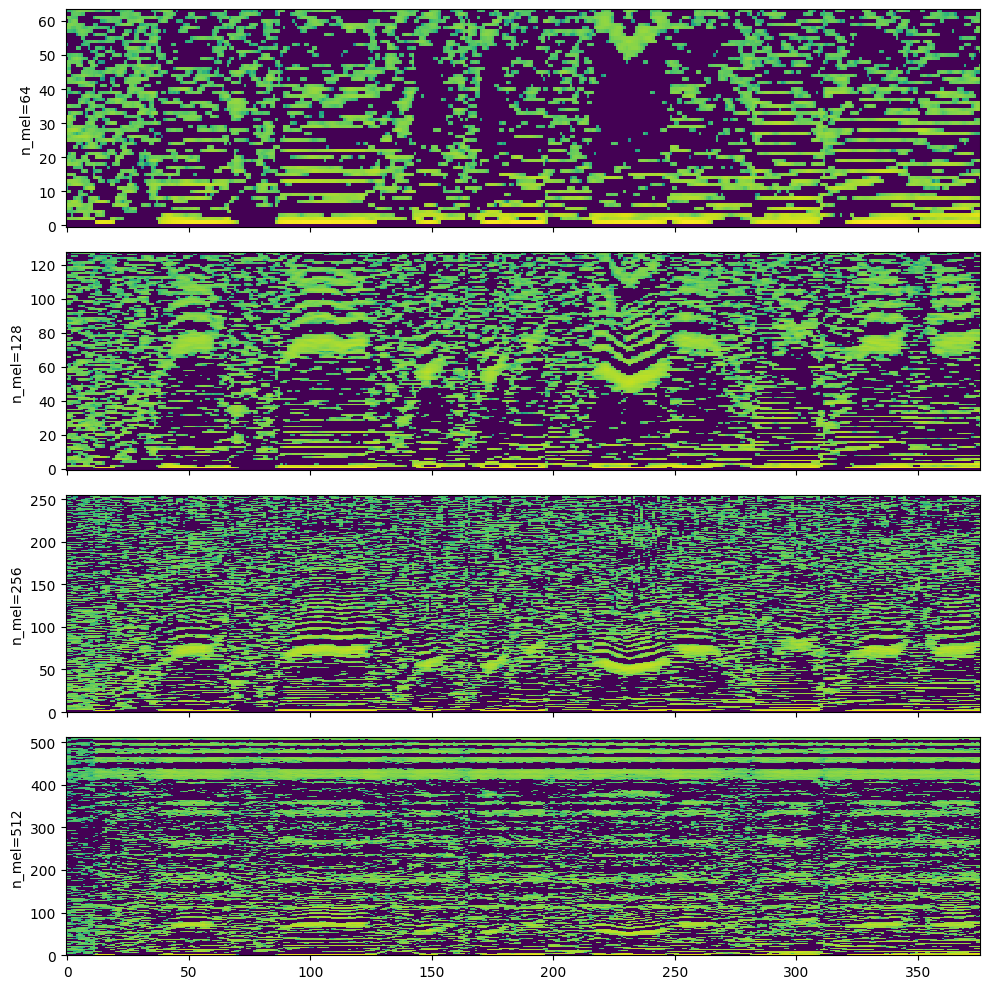

In [213]:
fig, axs = plt.subplots(len(specs), 1, figsize=(10, 10), sharex=True)

for i, (mfcc_test_n_mel, mfcc) in enumerate(zip(specs, mfccs)):
    plot_spectrogram(mfcc_test_n_mel[0], ylabel=f"n_mel={mfcc}", ax=axs[i])
    axs[i].set_xlabel(None)
    
fig.tight_layout()

#### 3.9. Conversión a LFCC




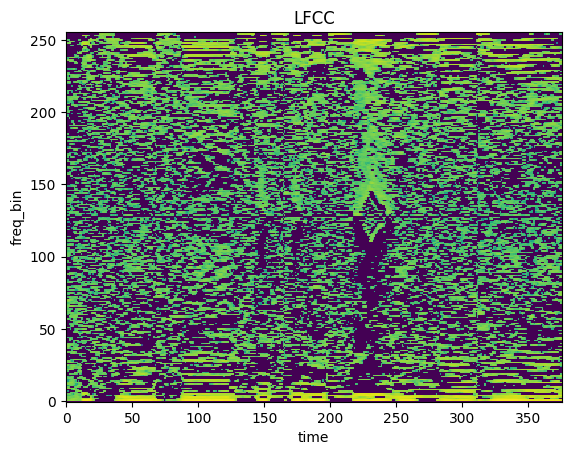

In [214]:
n_fft = 1024
win_length = None
hop_length = 128
n_lfcc = 256

lfcc_transform = T.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

lfcc = lfcc_transform(SPEECH_WAVEFORM_SPLICING)
plot_spectrogram(lfcc[0], title="LFCC")

#### 3.9.1. Pruebas cambiando el valor de ``n_lfcc``

#### 3.10. Estudio del Pitch

In [215]:
pitch = F.detect_pitch_frequency(SPEECH_WAVEFORM_SPLICING, SAMPLE_RATE_SPLICING)

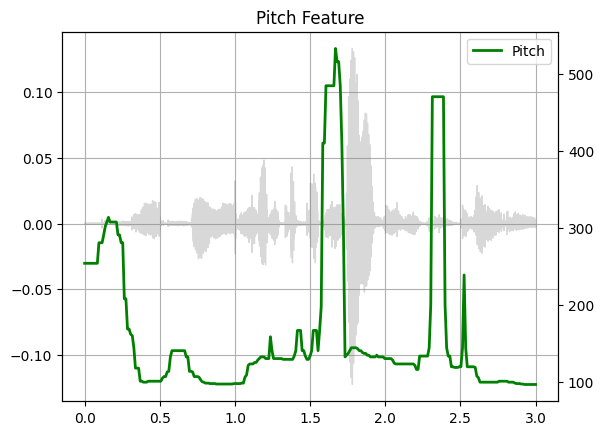

In [216]:
def plot_pitch(waveform, sr, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)


plot_pitch(SPEECH_WAVEFORM_SPLICING, SAMPLE_RATE_SPLICING, pitch)

## 4. Modificaciones del audio

#### 4.1. Máscaras


``SpecAugment``: técnica de aumento de datos para espectrogramas.

Aplicamos **máscaras de frecuencia y tiempo** al espectrograma para evitar el sobreajuste y ayudar al modelo a generalizar mejor. Este proceso de aumento de datos ayuda a mejorar el rendimiento y la capacidad de generalización del espectrograma.

La técnica de aumento de datos "SpecAugment" se utiliza para mejorar el rendimiento y la capacidad de generalización de los modelos de redes neuronales convolucionales entrenados en datos de audio.

In [217]:
# Maximum percentage of the spectrogram to mask
max_mask_pct = 0.05

# Number of frequency masks to apply
n_freq_masks = 1

#Number of time masks to apply
n_time_masks = 1


melspec_masking = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM_SPLICING.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels,
    htk=True,
    norm=None,
)

melspec_masking_tensor = torch.tensor(melspec_masking)
melspec_masking_tensor_augmented = melspec_masking_tensor

# Apply frequency masking
freq_mask_param = int(max_mask_pct * melspec_masking_tensor.shape[1])
for _ in range(n_freq_masks):
    melspec_masking_tensor_augmented = torchaudio.transforms.FrequencyMasking(freq_mask_param)(melspec_masking_tensor_augmented)

# Apply time masking
time_mask_param = int(max_mask_pct * melspec_masking_tensor.shape[1])
for _ in range(n_time_masks):
    melspec_masking_tensor_augmented = torchaudio.transforms.TimeMasking(time_mask_param)(melspec_masking_tensor_augmented)

Graficamos 

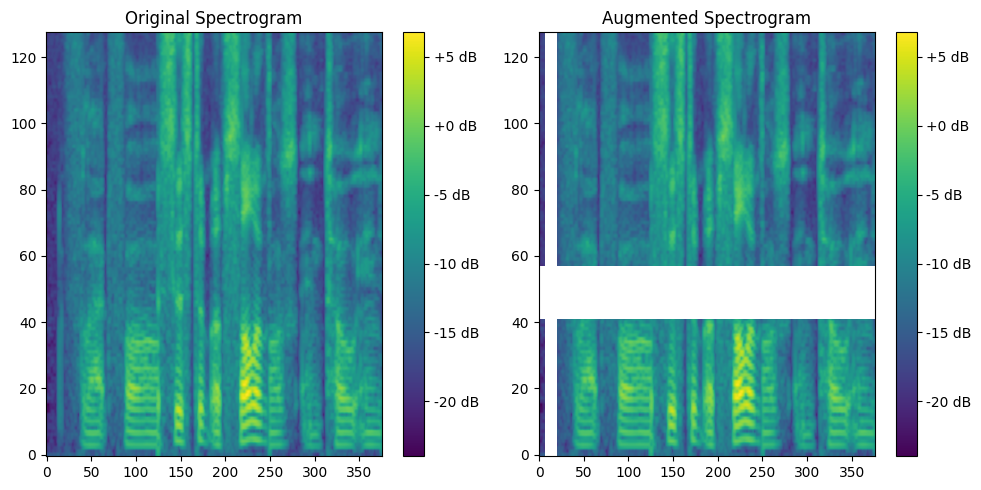

In [218]:
# Original spectrogram
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(melspec_masking_tensor.log2().numpy(), aspect='auto', origin='lower')
plt.title('Original Spectrogram')
plt.colorbar(format='%+2.0f dB')

# Augmented spectrogram
plt.subplot(1, 2, 2)
plt.imshow(melspec_masking_tensor_augmented.log2().numpy(), aspect='auto', origin='lower')
plt.title('Augmented Spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

### 4.2 Ruido Gaussiano

Ahora vamos a usar la libreria ``audiomentation`` para audio augmentation, y ver graficamente algunas de las modificaciones.

Primeramente vamos a añadirle rudio de fondo al audio original usando ``AddGaussianNoise``

In [219]:
def convert_spectogram(waveform, sample_rate):
    return librosa.feature.melspectrogram(
        y=waveform.squeeze(),
        sr=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        n_mels=n_mels,
        htk=True,
        norm=None,
    )


def plot_original_and_augmented(original_waveform, augmented_waveform, sample_rate):
    # Convert waveforms to Mel spectrograms
    original_spectrogram = convert_spectogram(original_waveform, sample_rate)
    augmented_spectrogram = convert_spectogram(augmented_waveform, sample_rate)

    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plot original waveform
    axs[0, 0].plot(original_waveform.squeeze())
    axs[0, 0].set_title('Original Waveform')
    axs[0, 0].set_xlabel('Sample')
    axs[0, 0].set_ylabel('Amplitude')

    # Plot augmented waveform
    axs[0, 1].plot(augmented_waveform.squeeze())
    axs[0, 1].set_title('Augmented Waveform')
    axs[0, 1].set_xlabel('Sample')
    axs[0, 1].set_ylabel('Amplitude')

    # Plot original spectrogram
    axs[1, 0].imshow(librosa.power_to_db(original_spectrogram, ref=np.max), aspect='auto', origin='lower')
    axs[1, 0].set_title('Original Spectrogram')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('Frequency')
    axs[1, 0].set_yticks([])
    axs[1, 0].set_xticks([])

    # Plot augmented spectrogram
    axs[1, 1].imshow(librosa.power_to_db(augmented_spectrogram, ref=np.max), aspect='auto', origin='lower')
    axs[1, 1].set_title('Augmented Spectrogram')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].set_yticks([])
    axs[1, 1].set_xticks([])

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


In [220]:
# Seleccionamos un audio random
_, _, audio_path = select_random_audio(ORIGINAL_DATASET_PATH)
#Mostramos su espec
# Load audios
waveform , sr = torchaudio.load(audio_path)


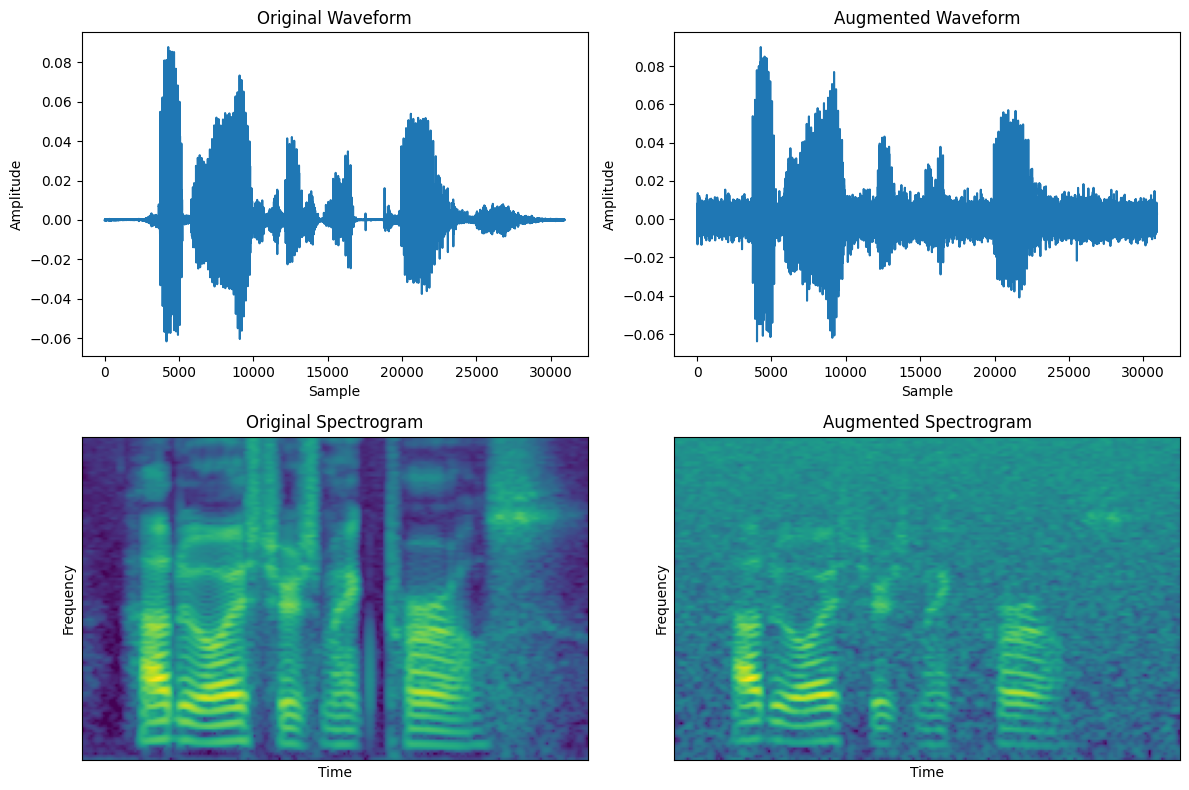

In [221]:
augment = AddGaussianNoise(
    min_amplitude=0.001,max_amplitude=0.005,p=1,
)
gaussian_result = augment(waveform,sample_rate=sr)

original_waveform_np = waveform.numpy()
gaussian_waveform_np = gaussian_result.numpy()

plot_original_and_augmented(original_waveform_np,gaussian_waveform_np,sr)

Audio original sin modificaciones

In [222]:
Audio(waveform.numpy(), rate=sr)

Audio con ruido gaussiano

In [223]:
Audio(gaussian_result, rate=sr)

### 4.3 Ganancia

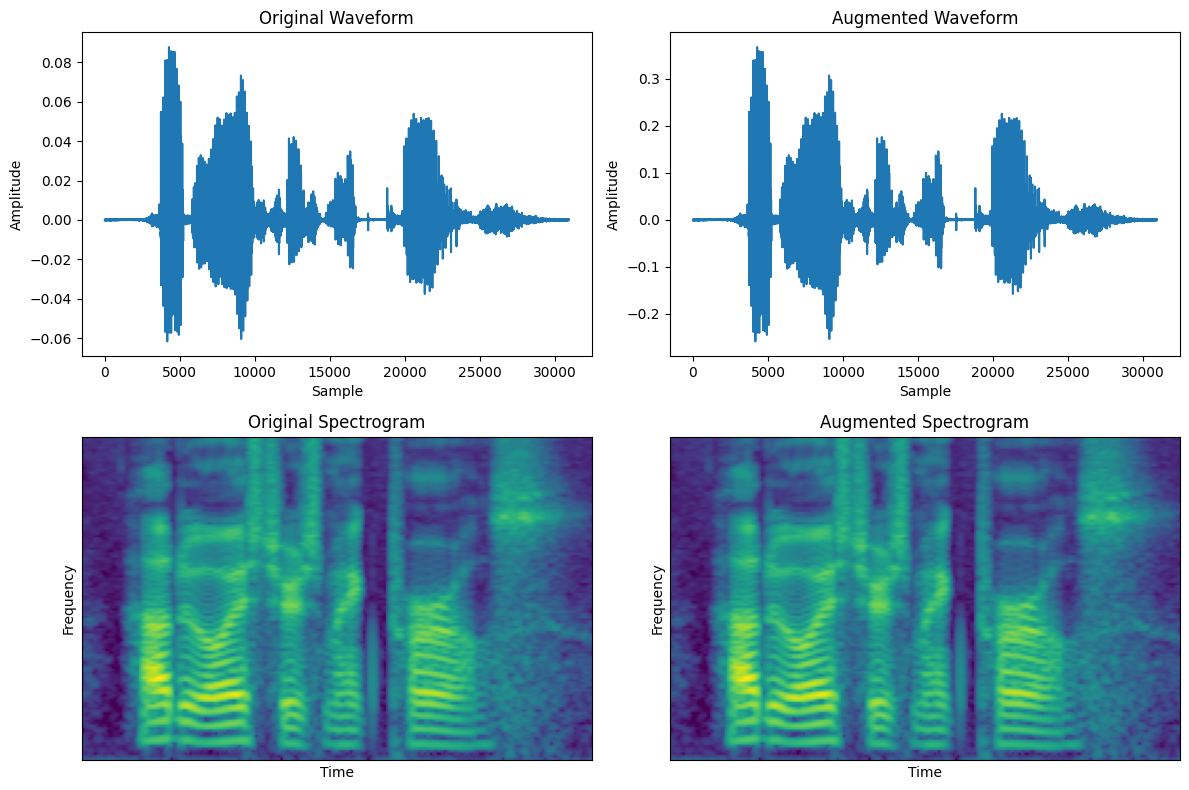

In [224]:
augment = Gain(
    min_gain_db=10.0,
    max_gain_db=30.0,
    p=1,
)
gain_result = augment(waveform,sample_rate=sr)

original_waveform_np = waveform.numpy()
gain_waveform_np = gain_result.numpy()

plot_original_and_augmented(original_waveform_np,gain_waveform_np,sr)

Audio original sin modificaciones

In [225]:
Audio(waveform.numpy(), rate=sr)

Audio con Ganancia

In [226]:
Audio(gain_result, rate=sr)

### 4.4 Pitch Shift

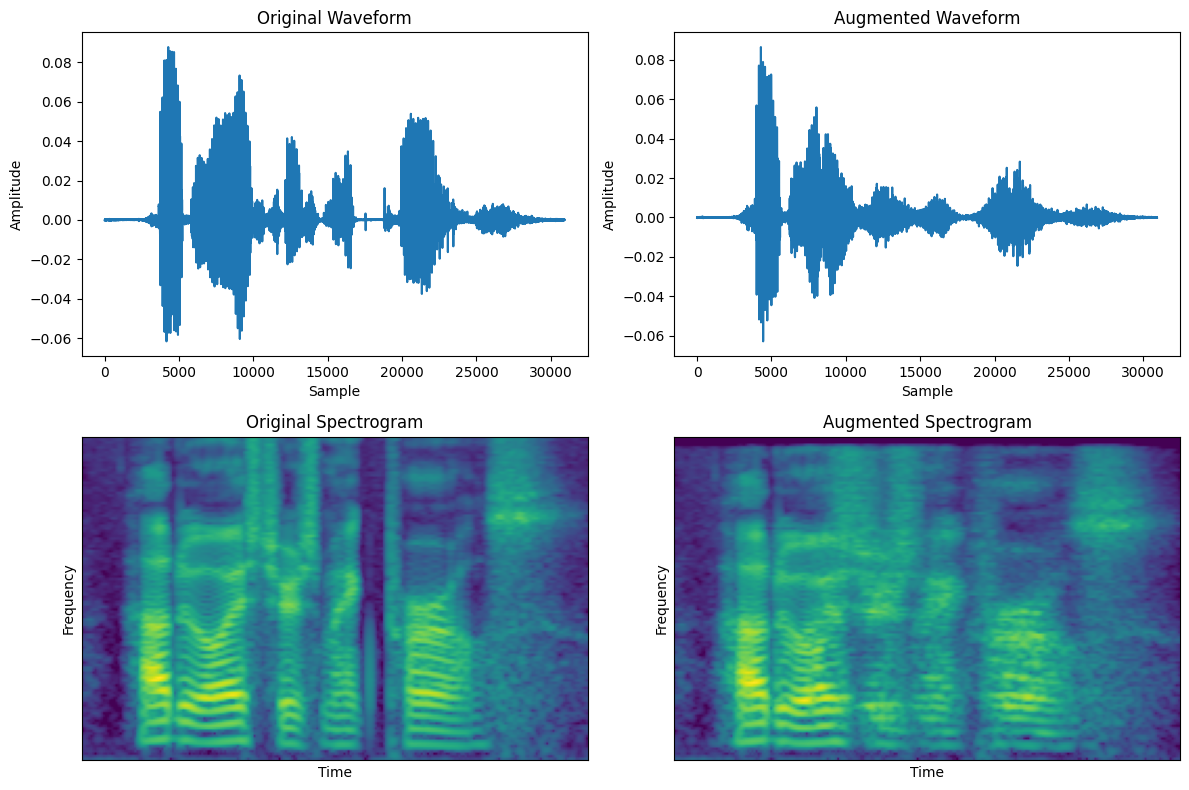

In [227]:
augment = PitchShift(min_semitones=-2, max_semitones=2, p=1)

augmented_result = augment(waveform,sample_rate=sr)

# Convertir los tensores de PyTorch a matrices de NumPy
original_waveform_np = waveform.squeeze().numpy()
pitch_waveform_np = augmented_result.squeeze()

plot_original_and_augmented(original_waveform_np, pitch_waveform_np, sr)

Audio original sin modificaciones

In [228]:
Audio(original_waveform_np, rate=sr)

Audio con PitchShift

In [229]:
Audio(pitch_waveform_np, rate=sr)

### 4.5 Reverse

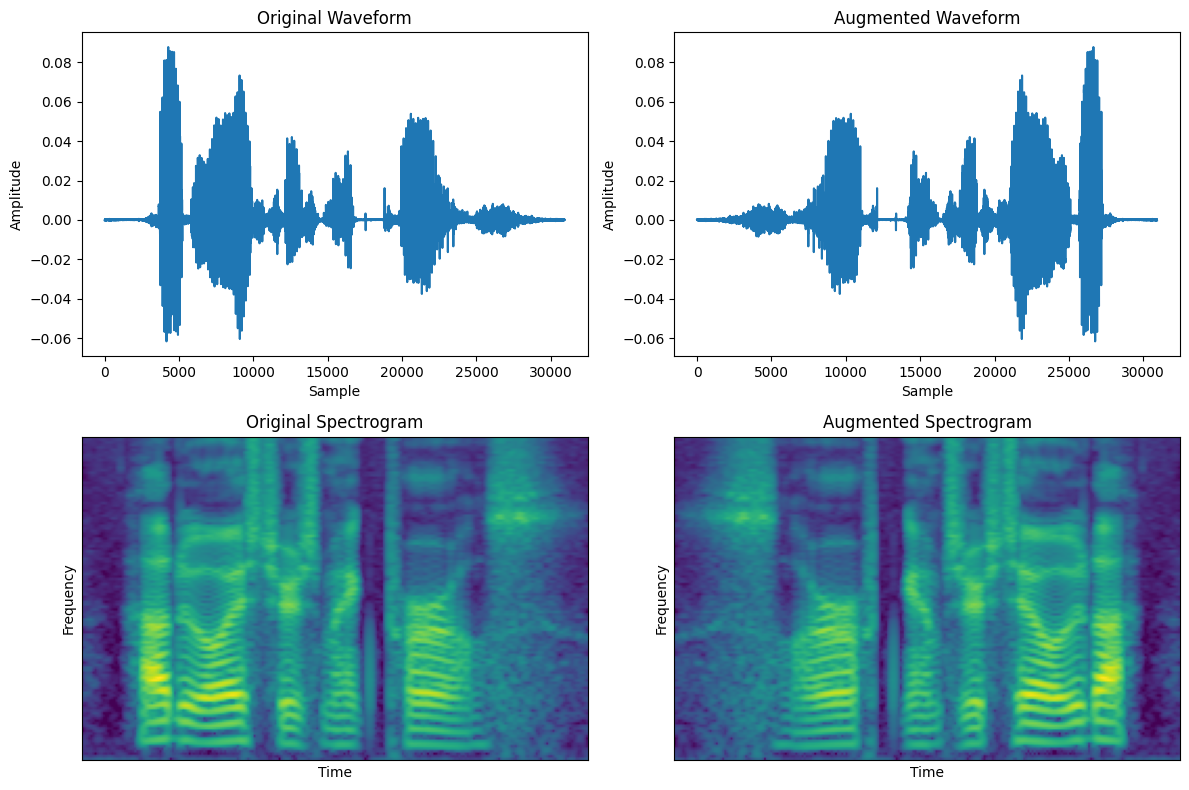

In [230]:
augment = Reverse(
    p = 1
)

augmented_result = augment(waveform,sample_rate=sr)

# Convertir los tensores de PyTorch a matrices de NumPy
original_waveform_np = waveform.squeeze().numpy()
reverse_waveform_np = augmented_result.squeeze()

plot_original_and_augmented(original_waveform_np, reverse_waveform_np, sr)

Audio original sin modificaciones

In [231]:
Audio(original_waveform_np, rate=sr)

Audio con Reverse

In [232]:
Audio(reverse_waveform_np, rate=sr)

In [235]:
def plot_all_augmented(original_waveform, gaussian_waveform, gain_waveform, pitch_waveform, reverse_waveform, sample_rate):
    # Convert waveforms to Mel spectrograms
    original_spectrogram = convert_spectogram(original_waveform, sample_rate)
    gaussian_spectrogram = convert_spectogram(gaussian_waveform, sample_rate)
    gain_spectrogram = convert_spectogram(gain_waveform, sample_rate)
    pitch_spectrogram = convert_spectogram(pitch_waveform, sample_rate)
    reverse_spectrogram = convert_spectogram(reverse_waveform, sample_rate)

    spectograms = [original_spectrogram, gaussian_spectrogram, gain_spectrogram, pitch_spectrogram, reverse_spectrogram]
    waveforms = [original_waveform, gaussian_waveform, gain_waveform, pitch_waveform, reverse_waveform]
    strings = ["Original", "Ruido Gaussiano", "Ganancia", "Tono", "Revertido"]

    # Create a figure with subplots
    fig, axs = plt.subplots(len(spectograms), 2, figsize=(10, 14))

    for i in range(len(spectograms)):
        # Plot original waveform
        axs[i, 0].plot(waveforms[i].squeeze())
        axs[i, 0].set_title(strings[i] + ' onda de audio')
        axs[i, 0].set_xlabel('Muestra')
        axs[i, 0].set_ylabel('Amplitud')

        # Plot original spectrogram
        axs[i, 1].imshow(librosa.power_to_db(spectograms[i], ref=np.max), aspect='auto', origin='lower')
        axs[i, 1].set_title(strings[i] + ' espectograma')
        axs[i, 1].set_xlabel('Tiempo')
        axs[i, 1].set_ylabel('Frecuencia')
        axs[i, 1].set_yticks([])
        axs[i, 1].set_xticks([])

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


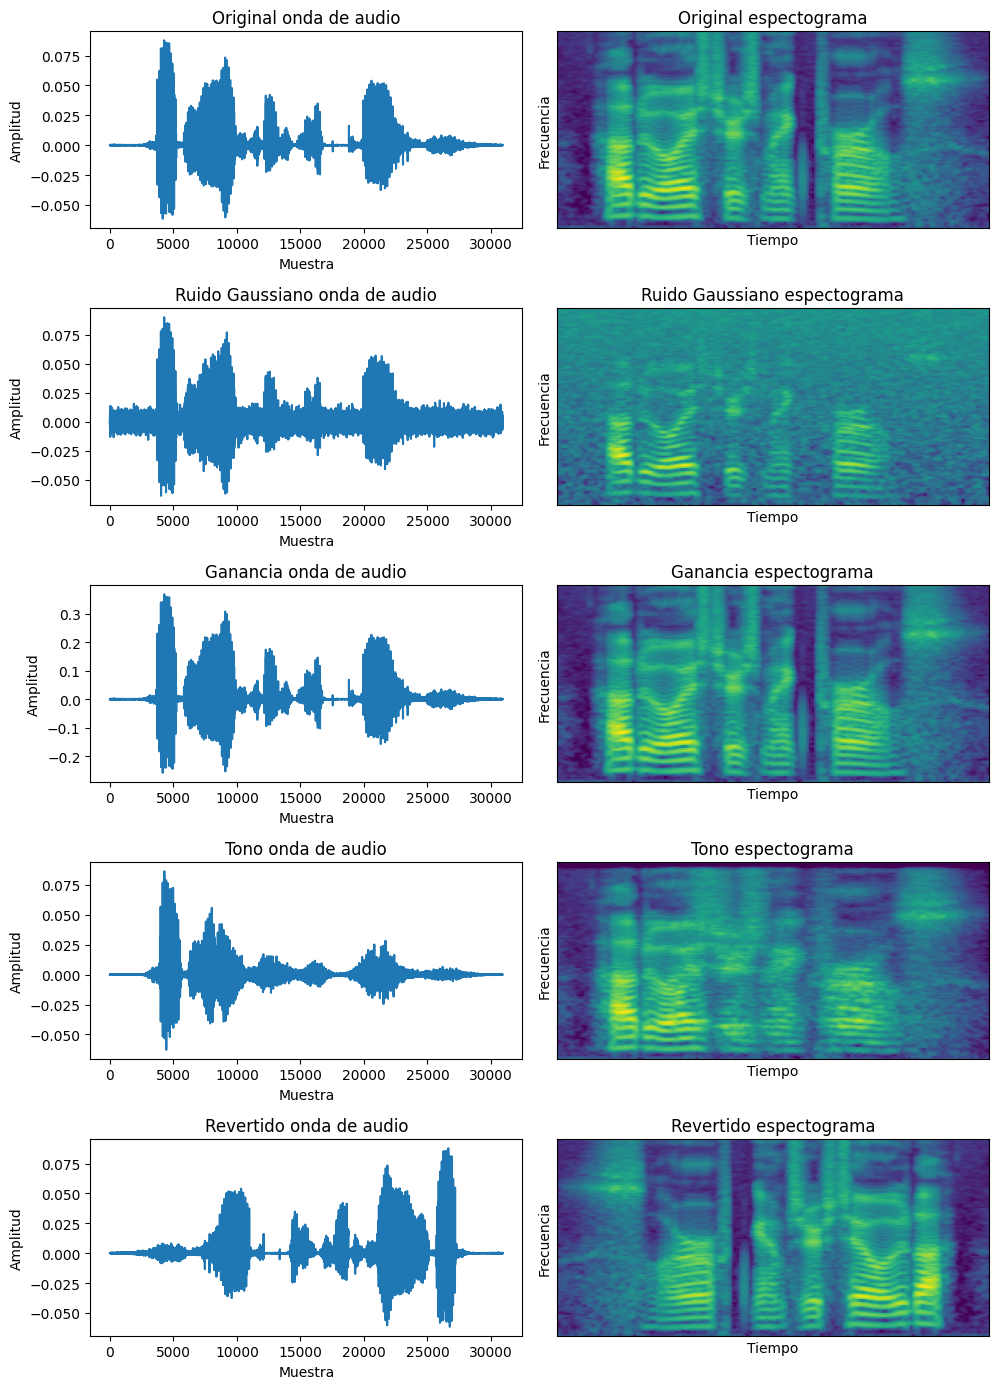

In [236]:
plot_all_augmented(original_waveform_np, gaussian_waveform_np, gain_waveform_np, pitch_waveform_np, reverse_waveform_np, sr)